In [1]:
import os
import pickle
import timeit
from datetime import datetime, timedelta
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nlct_dir_path = "/mnt/data2/jturner/nlct_data/georges_bank/"

In [3]:
nlct_dates = sorted(os.listdir(nlct_dir_path))

#--- Removing any non-date directory items
#--- Currently only including 2023
nlct_dates = [x for x in nlct_dates if x[:4] == '2023']
nlct_dates

['20230101',
 '20230102',
 '20230103',
 '20230104',
 '20230105',
 '20230106',
 '20230107']

Creating the static feature function: 

In [4]:
def get_static_features(BTD_c, nlct_dir_path, nlct_date):
    #--- Initialize an array of 1's in the shape of the final image
    BTD_prod = [ [1]*len(BTD_c[0][0]) for i in range(len(BTD_c[0]))]

    #--- Starting the timer
    starttime = timeit.default_timer()

    #--- Include all times or just top of hour (TOH)
    all_files = sorted(os.listdir(nlct_dir_path+nlct_date+'/'))
    toh_files = [filename for filename in all_files if filename.endswith('00M')]

    for filename in toh_files:

            #--- Open the NLCT file
            file = open(nlct_dir_path+nlct_date+'/'+filename, 'rb')
            BTD = pickle.load(file)
            file.close()

            #--- Crop to the specified region
            BTD = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
            BTD = BTD.dropna(dim="y", how="all")
            BTD = BTD.dropna(dim="x", how="all")

            #--- Set negative values to zero
            BTD = np.where(BTD < 0, 0, BTD)

            #--- V1: Multiply to only enhance static clouds
            #BTD_prod = BTD_prod*BTD

            #--- V1: Limit runaway large values to 3
            #BTD_prod = np.where(BTD_prod > 3, 3, BTD_prod)
            
            #--- Mitigating error where BTD is not loaded
            #if np.shape(BTD) != np.shape(BTD_prod):
                #print('mismatched shapes')
            
            #--- V2: Sum to enhance static clouds
            BTD_prod = np.array(BTD_prod)+np.array(BTD)
            
            #print(filename)
            #print('BTD: ', np.shape(BTD), 'BTD_prod: ', np.shape(BTD_prod))


    #print("Completed: ", timeit.default_timer() - starttime)

    return BTD_prod

Creating the static value function: 
* currently calculates each day twice, can make more efficient

In [5]:
def get_static_values(BTD_c, nlct_dir_path, nlct_date):
    
    BTD_prod = get_static_features(BTD_c, nlct_dir_path, nlct_date)
    
    #--- Create date variable
    date = datetime.strptime(nlct_date, "%Y%m%d")
    
    #--- Get the next day in sequence
    date2 = date + timedelta(days=1)
    nlct_date2 = date2.strftime("%Y%m%d")

    #--- Run static features for the next day
    BTD_prod2 = get_static_features(BTD_c, nlct_dir_path, nlct_date2)
    
    #--- Combine current day and next day static features
    BTD_tot = BTD_prod + BTD_prod2
    
    #--- V2: Limit to top 25%
    BTD_tot_lim = np.nan_to_num(BTD_tot, nan=0)
    BTD_tot_lim = BTD_tot_lim/np.max(BTD_tot_lim)
    limit = 0.75
    BTD_tot_lim = np.where(BTD_tot_lim < limit, 0, BTD_tot_lim)
    BTD_tot_lim = np.where(BTD_tot_lim > limit, 1, BTD_tot_lim)

    #--- Convert BTD prod (2d array) to value
    static_value = np.nansum(BTD_tot_lim)
    
    return date, static_value

Create sample to use as framework for loop:

In [6]:
sample_date = '20230101'
sample_nlct_path = nlct_dir_path+sample_date+"/"
sample_filename = 'goes_e_ntlc_'+sample_date[0:4]+'_'+sample_date[4:6]+'_'+sample_date[6:8]+'_00H_00M'

file = open(sample_nlct_path+sample_filename, 'rb')
BTD = pickle.load(file)
file.close()

#---Georges Bank
min_lon = -70.5
min_lat = 39
max_lon = -67
max_lat = 43

BTD_c = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
BTD_c = BTD_c.dropna(dim="y", how="all")
BTD_c = BTD_c.dropna(dim="x", how="all")

Running the static value function for each date in NLCT directory: 

In [7]:
data = {'Date': [], 'StaticValue': []}
df = pd.DataFrame(data)

In [8]:
for nlct_date in tqdm(nlct_dates[:-1], desc="Processing", ncols=100):
    date, static_value = get_static_values(BTD_c, nlct_dir_path, nlct_date)
    #print(date, static_value)
    
    data_to_add = {
        'Date': date,
        'StaticValue': static_value
    }
    df = df.append(data_to_add, ignore_index=True)

Processing: 100%|█████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.64it/s]


In [9]:
df

,Date,StaticValue
0,2023-01-01,32.0
1,2023-01-02,724.0
2,2023-01-03,63.0
3,2023-01-04,46.0
4,2023-01-05,683.0
5,2023-01-06,579.0


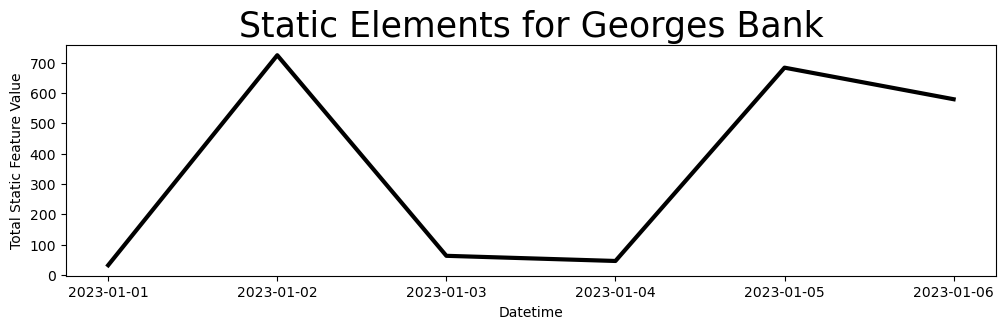

In [10]:
fig,ax=plt.subplots(1, figsize=(12,3))
ax.set_ylabel("Total Static Feature Value", fontsize=10)
ax.set_xlabel("Datetime", fontsize=10)
ax.set_title("Static Elements for Georges Bank", fontsize=25)

ax.plot(df.Date, df.StaticValue, c='black', linewidth=3)